# Imports, Variables & Function definitions

In [50]:



#Imports
import tensorflow as tf
from keras.datasets import mnist
import foolbox as fb
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from sklearn.neighbors import NearestNeighbors
from itertools import product
from scipy.ndimage.interpolation import rotate, shift



#Variables
epsilon=0.3
batch_size=1024
epochs=1000
pgd_steps=50
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Foolbox version: ", fb.__version__)
print(tf.config.list_physical_devices('GPU'))
np.random.seed(10)


#get MNIST data and prepare
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows = img_cols = 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_train, x_test = x_train / 255.0, x_test / 255.0

#define variables needed for attacks
x_attack_to_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_attack_to_train=x_attack_to_train[:,:,:,np.newaxis]
y_attack_to_train=tf.convert_to_tensor(y_train, dtype=tf.int32)

x_attack_to_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
x_attack_to_test=x_attack_to_test[:,:,:,np.newaxis]
y_attack_to_test=tf.convert_to_tensor(y_test, dtype=tf.int32)

#for generating invariance-based adversarial examples
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()




#Functions
def test_model(model):
    
    assert epsilon==0.3
    inv_advs_to_test=np.load("data/invariance_examples_tramer/linf/automated_eps03.npy")[0:100]
    inv_labels_to_test=np.load("data/invariance_examples_tramer/linf/automated_eps03_labels.npy")[0:100]
    fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))      
    attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(steps=pgd_steps)

    # x_batch,y_batch=next_batch(100,x_test,y_test)
    x_batch,y_batch=x_test[0:100],y_test[0:100]
    x_batch_to_test = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    y_batch_to_test=tf.convert_to_tensor(y_batch, dtype=tf.int32)

    _,advs_to_test, success=attack(fmodel,x_batch_to_test, y_batch_to_test, epsilons=epsilon)
   
    
    success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
    x=tf.keras.backend.get_value(advs_to_test)
    ptb_test=x

    #get accuracies and losses
    acc =model.evaluate(x_test[0:100],to_categorical(y_test[0:100]), verbose=0)
    acc_ptb = model.evaluate(ptb_test,to_categorical(y_batch), verbose=0)
    acc_inv = model.evaluate(inv_advs_to_test,to_categorical(inv_labels_to_test), verbose=0)


    # get invariance adversarial examples success rate
    predictions=model.predict(inv_advs_to_test)
    disagreeing=0
    for i in range(len(predictions)):
        if inv_labels_to_test[i] !=np.argmax(predictions[i]):
            disagreeing+=1
    # plt.imshow(ptb_test[0], cmap='gray')
    # plt.show()  
   
      
    return {
    "clean":{"loss": acc[0], "accuracy":acc[1]},
    "ptb":{"loss": acc_ptb[0], "accuracy":acc_ptb[1]},
    "inv":{"loss": acc_inv[0], "accuracy":acc_inv[1]},
    "inv_success_rate":disagreeing/100}


def create_vanilla_model():
      print("creating vanilla model...")
      
      val_images = x_train[:10000]
      partial_images = x_train[10000:]
      val_labels = y_train[:10000]
      partial_labels = y_train[10000:]

      model = Sequential()

      model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Flatten())
      model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
      model.add(Dense(10, activation='softmax'))
     


      earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 1, 
                                        restore_best_weights = True)

      model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
      print("training vanilla model...")
      history=model.fit(partial_images,to_categorical(partial_labels),
                  validation_data =(val_images, to_categorical(val_labels)),
                  batch_size=batch_size,
                  epochs=epochs,
                  shuffle=True,
                  verbose=2,
                  callbacks =[earlystopping]
                  )
      print(np.shape(x_test))
      acc = model.evaluate(x_test[0:100],to_categorical(y_test[0:100]))
      print('BEFORE RETRAIN: Accuracy on clean testing data', acc[1])

      return model

def create_vanilla_model_tramer(filters=64, s1=5, s2=5, s3=3,
               d1=0, d2=0, fc=256,
               lr=1e-3, decay=1e-3):
    model = Sequential()
    model.add(Conv2D(filters, kernel_size=(s1, s1),
                     activation='relu',
                     input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters*2, (s2, s2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters*2, (s3, s3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(d1))
    model.add(Flatten())
    model.add(Dense(fc, activation='relu'))
    model.add(Dropout(d2))
    model.add(Dense(10))
    
   

    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

    final = Sequential()
    final.add(model)
    final.add(Activation('softmax'))
    final.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        
    final.fit(x_train, to_categorical(y_train, 10),
              batch_size=256,
              epochs=20,
              shuffle=True,
              verbose=2,
    )
    return final    


# https://stackoverflow.com/questions/40994583/how-to-implement-tensorflows-next-batch-for-own-data
# Get random batch of data
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


# https://github.com/ftramer/Excessive-Invariance
def linf_attack(x, nn_adv, eps):
    x_adv = x.copy().astype(np.float32)
    nn_adv = nn_adv.astype(np.float32)
    
    # if possible, change the pixels to the target value
    idx = np.where((np.abs(nn_adv - x) <= eps*255.) & (x > 0))
    x_adv[idx] = nn_adv[idx]
    
    # otherwise, go as close as possible
    idx = np.where(np.abs(nn_adv - x) > eps*255.)
    sign = np.sign(nn_adv - x)
    x_adv[idx] += sign[idx] * eps * 255.
    
    x_adv = np.clip(x_adv, x.astype(np.float32) - eps*255, x.astype(np.float32) + eps*255)
    x_adv = np.clip(x_adv, 0, 255.)
    
    return x_adv


# https://github.com/ftramer/Excessive-Invariance
# tries all rotation-translations of the input and returns the closest neighbor from each class
def get_best_neighbors(x, y, all_NNs, grid):
    xs = [shift(rotate(x, r, reshape=False), (tx, ty)).reshape(784) for (tx, ty, r) in grid]
    xs = np.asarray(xs.copy())
    
    nns = []
    y_nns = []
    grids_nn = []
    
    # find a nearest neighbor in each class
    for i in range(10):
        if i != y:
            X = X_train[Y_train == i]
            Y = Y_train[Y_train == i]
            distances, indices = all_NNs[i].kneighbors(xs, n_neighbors=1)

            best = np.argmin(np.reshape(distances, -1))
            best_idx = np.reshape(indices, -1)[best]
            nns.append(X[best_idx])
            y_nns.append(Y[best_idx])
            
            # store the inverse rotation+translation to be applied to the target
            grids_nn.append(-np.asarray(grid[best]))
    
    return nns, y_nns, grids_nn


# https://github.com/ftramer/Excessive-Invariance
def generate_inv_adv_examples(epsilon_to_use, count):
    import numpy as np
    assert epsilon_to_use==0.3 or epsilon_to_use==0.4
    
    idxs=np.arange(0,300,1,dtype=int)

    #  Load the MNIST data. 300 randomly chosen test point
    assert len(idxs) == count
    test_xs = X_test[idxs]
    test_ys = Y_test[idxs]

    # build a nearest neighbors classifier per class
    N = 1
    all_NNs = []

    for i in range(10):
        #Reshape to 1D (28*28=784)
        X = X_train[Y_train == i].reshape(-1, 784)
        nn = NearestNeighbors(n_neighbors=N)
    
        nn.fit(X)
        all_NNs.append(nn)
    # print(all_NNs)



    # Rotation-translation parameters
    limits = [3, 3, 30]
    granularity = [5, 5, 31]
    grid = list(product(*list(np.linspace(-l, l, num=g) for l, g in zip(limits, granularity))))




    all_nns = []
    all_y_nns = []
    all_grids_nns = []

    # find nearest neighbors for some test inputs (this takes a little while)
    for i in range(len(idxs)):
        if i % 10 == 0:
            print("{}/{} done".format(i, len(idxs)))
        x = test_xs[i]
        y = test_ys[i]

        # find the nearest neighbors for each class, with the corresponding rotation and translation
        nns, y_nns, grids_nns = get_best_neighbors(x, y, all_NNs, grid)
        nn_advs = [shift(rotate(nn, r, reshape=False), (tx, ty)) for (nn, (tx, ty, r)) in zip(nns, grids_nns)]
        all_nns.append(nn_advs)
        all_y_nns.append(y_nns)
        all_grids_nns.append(np.asarray(grids_nns))



    # save everything!
    np.save("data/invariance_examples_generation/X_test_{}.npy".format(count), test_xs)
    np.save("data/invariance_examples_generation/all_nns.npy", np.asarray(all_nns))
    np.save("data/invariance_examples_generation/all_y_nns.npy", np.asarray(all_y_nns))
    np.save("data/invariance_examples_generation/all_grids_nns.npy", np.asarray(all_grids_nns))



    # (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    all_nns=np.load("data/invariance_examples_generation/all_nns.npy")
    all_y_nns=np.load("data/invariance_examples_generation/all_y_nns.npy")
    all_grids_nns=np.load("data/invariance_examples_generation/all_grids_nns.npy")
    test_xs=np.load("data/invariance_examples_generation/X_test_{}.npy".format(count))
  
    test_ys = y_test[idxs]

    # manually chosen target classes for each source class
    targets = {
        0: [4, 6, 8, 9],
        1: [4, 6, 7, 9],
        2: [8],
        3: [8],
        4: [8, 9],
        5: [3, 8],
        6: [0],
        7: [2, 3],
        8: [3],
        9: [3, 4, 5]
    }

    best_y_advs = []
    best_targets = []
    best_advs = []

    for i in range(len(all_nns)):
        x = test_xs[i]
        y = test_ys[i]
    
        best_x_adv = None
        best_nn_adv = None
        amount_removed = []
        amount_added = []
        rot = []
        best_y = None
        min_removed = np.inf
        for j in range(len(all_nns[i])):
            nn_adv = all_nns[i][j]
            y_nn = all_y_nns[i][j]
            # print("NN ADV: {}".format(np.shape(nn_adv)))
            # print("X: {}".format(np.shape(x)))
            x_adv = linf_attack(x, nn_adv, epsilon_to_use)
        
            
            # retain the target that required the least amount of pixels to be "removed"
            curr_rot = np.abs(all_grids_nns[i][j][-1])
            curr_removed = np.sum(np.abs(np.maximum(x/255. - x_adv/255., 0)))
            
            if y_nn in targets[y] and curr_removed < min_removed:
                min_removed = curr_removed
                best_y = y_nn
                best_x_adv = x_adv
                best_nn_adv = (nn_adv, y_nn)
                    
        best_targets.append(best_nn_adv)
        best_advs.append(best_x_adv)
        best_y_advs.append(best_y)
        

    
    if epsilon_to_use==0.3:
        np.save("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples", best_advs)
        np.save("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples_new_labels", best_y_advs)
    else:
        np.save("data/invariance_examples/epsilon_0.4/invariance-based_adversarial_examples", best_advs)
        np.save("data/invariance_examples/epsilon_0.4/invariance-based_adversarial_examples_new_labels", best_y_advs)
    



Tensorflow version:  2.8.0
Numpy version:  1.22.2
Foolbox version:  3.3.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Create/train vanilla model

In [ ]:
create_vanilla_model().save("models/vanilla_model")

# Attack Vanilla Model and Retrain with Perturbation-Based Adversarial Examples iteratively
Result is ptb_trained_model

Takes a few minutes

In [ ]:
#get Model
model=load_model("models/vanilla_model")

ptb_acc_to_achieve=0.88
ptb_acc=0
i=0
y_axis=[]
x_axis_ptb=[]
x_axis_clean=[]

attack = fb.attacks.projected_gradient_descent.LinfProjectedGradientDescentAttack(steps=pgd_steps)
# print("Attacking and retraining ",iterations," times (Can take a couple of minutes):")

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 1, 
                                        restore_best_weights = True)

#While ACCURACY
while ptb_acc<=ptb_acc_to_achieve:
    res=test_model(model)
    ptb_acc=res.get("ptb").get("accuracy")
    clean_acc=res.get("clean").get("accuracy")

    i+=1
    y_axis.append(i)
    x_axis_ptb.append(ptb_acc)
    x_axis_clean.append(clean_acc)
    fmodel=fb.models.tensorflow.TensorFlowModel(model, bounds=(0,1))   
    x_batch,y_batch=next_batch(50,x_train,y_train)
    x_batch_to_train = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    y_batch_to_train=tf.convert_to_tensor(y_batch, dtype=tf.int32)

    #attack model    
    _,advs, success=attack(fmodel, x_batch_to_train, y_batch_to_train, epsilons=epsilon) 
    success_rate=tf.keras.backend.get_value(success).mean(axis=-1).round(2)
    
    #Retrain model with generated perturbation-based adversarial examples
    #80% Training 20% Validation
    x=tf.keras.backend.get_value(advs)
    # print("Shape of x_training before reshape: {}".format(np.shape(x)))
    # print("Shape of x_training after reshape: {}".format(np.shape(x)))
    x_training=x[0:int(len(x)*0.8)]
    x_validation=x[int(len(x)*0.8):int(len(x))]
    y_training=y_batch[0:int(len(x)*0.8)]
    y_validation=y_batch[int(len(x)*0.8):int(len(x))]
    
    model.fit(x_training,to_categorical(y_training,num_classes=10),
        validation_data =(x_validation,to_categorical(y_validation, num_classes=10)),
        epochs=epochs,
        verbose=0,
        callbacks =[earlystopping]
    )
   

    print("i: {} ptb acc: {}".format(i,ptb_acc))
model.save("models/ptb_trained_model_{}_ptb_accuracy".format(ptb_acc))



plt.plot( y_axis, x_axis_clean, label = "Clean")
plt.plot( y_axis, x_axis_ptb,label = "PTB")
plt.xlabel('Iterationen')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# Plot PTB Adversarial Training graphs

In [ ]:
def filter_array(array):
    filtered=[]
    for i in range(len(array)):
        if i%10==0:
            filtered.append(array[i])
    return filtered



y=np.load("data/ptb_training/iteration_count_arr.npy")
clean_arr=np.load("data/ptb_training/clean_accuracy_arr.npy")
ptb_arr=np.load("data/ptb_training/ptb_accuracy_arr.npy")
plt.plot( y, clean_arr, label = "Clean")
plt.plot( y, ptb_arr,label = "PTB")
plt.xlabel('Iterationen')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

new_arr_x_ptb=filter_array(ptb_arr)
new_arr_x_clean=filter_array(clean_arr)
new_arr_y=filter_array(y)


plt.plot( new_arr_y, new_arr_x_clean, label = "Clean")
plt.plot( new_arr_y, new_arr_x_ptb,label = "PTB")
plt.xlabel('Iterationen')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Max accuracy against PTB: {}".format(np.max(ptb_arr)))



# Generate INV-Based ADV-Examples 
Code is from https://github.com/ftramer/Excessive-Invariance

In [51]:

generate_inv_adv_examples(0.3,300)
generate_inv_adv_examples(0.4,300)



0/300 done
10/300 done
20/300 done
30/300 done
40/300 done
50/300 done
60/300 done
70/300 done
80/300 done
90/300 done
100/300 done
110/300 done
120/300 done
130/300 done
140/300 done
150/300 done
160/300 done
170/300 done
180/300 done
190/300 done
200/300 done
210/300 done
220/300 done
230/300 done
240/300 done
250/300 done
260/300 done
270/300 done
280/300 done
290/300 done
0/300 done
10/300 done
20/300 done
30/300 done
40/300 done
50/300 done
60/300 done
70/300 done
80/300 done
90/300 done
100/300 done
110/300 done
120/300 done
130/300 done
140/300 done
150/300 done
160/300 done
170/300 done
180/300 done
190/300 done
200/300 done
210/300 done
220/300 done
230/300 done
240/300 done
250/300 done
260/300 done
270/300 done
280/300 done
290/300 done


# Plot INV-Based ADV-Examples

EPSILON=0.3


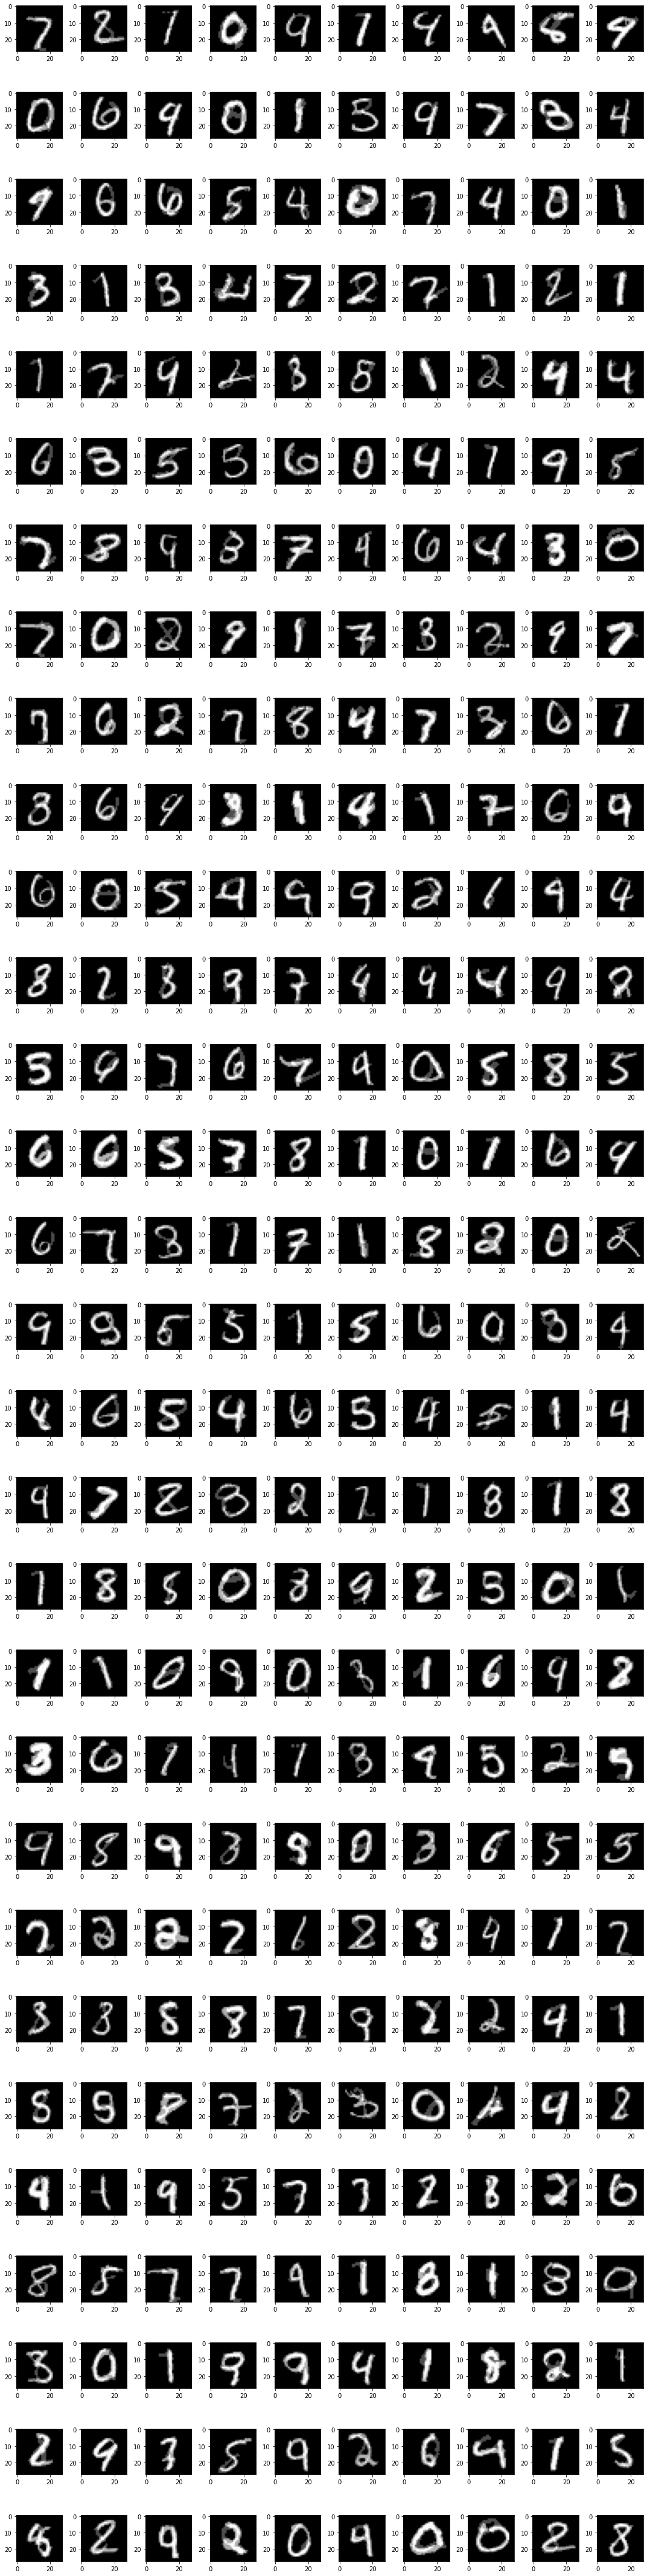

EPSILON=0.4


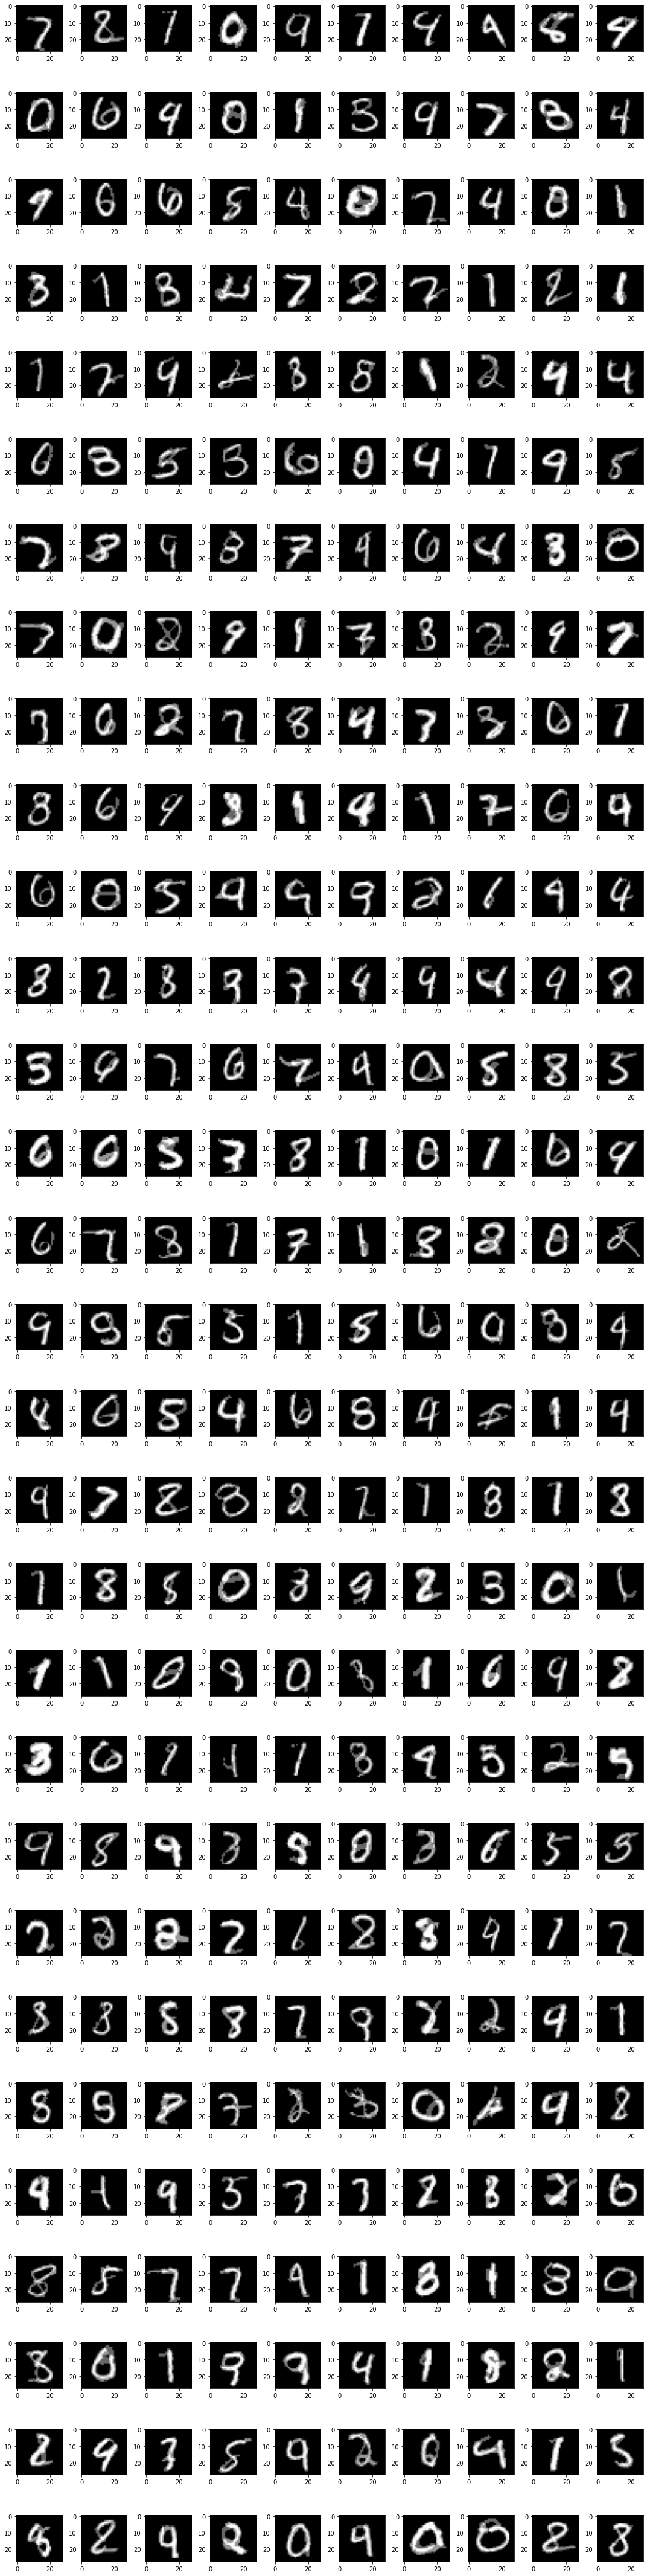

In [58]:
inv_advs_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples.npy")
inv_labels_to_train=np.load("data/invariance_examples/epsilon_0.3/invariance-based_adversarial_examples_new_labels.npy")

print("EPSILON=0.3")
fig, axes = plt.subplots(30,10, figsize=(1.5*10,2*30))
for i in range(300):
    ax = axes[i//10,i%10]
    ax.imshow(inv_advs_to_train[i], cmap='gray')
    # ax.set_title('Label: {}'.format(inv_labels_to_train[i]))
plt.tight_layout()
plt.show()

inv_advs_to_train=np.load("data/invariance_examples/epsilon_0.4/invariance-based_adversarial_examples.npy")
inv_labels_to_train=np.load("data/invariance_examples/epsilon_0.4/invariance-based_adversarial_examples_new_labels.npy")

print("EPSILON=0.4")
fig, axes = plt.subplots(30,10, figsize=(1.5*10,2*30))
for i in range(300):
    ax = axes[i//10,i%10]
    ax.imshow(inv_advs_to_train[i], cmap='gray')
    # ax.set_title('Label: {}'.format(inv_labels_to_train[i]))
plt.tight_layout()
plt.show()

# Retrain Models with Invariance-Based Adversarial Examples

In [30]:
#Load data and model
vanilla_model=load_model("models/vanilla_model")
ptb_trained_model=load_model("models/ptb_trained_model_0.889_ptb_accuracy")


# inv_advs_to_train=np.load("data/invariance_examples/invariance-based_adversarial_examples.npy")
# inv_labels_to_train=np.load("data/invariance_examples/invariance-based_adversarial_examples_labels.npy")

inv_advs_to_train=np.load("data/invariance_examples_tramer/linf/automated_eps03.npy")[0:10]
inv_labels_to_train=np.load("data/invariance_examples_tramer/linf/automated_eps03_labels.npy")[0:10]


#retrain with inv-based adv examples
vanilla_model.fit(inv_advs_to_train,to_categorical(inv_labels_to_train,num_classes=10),
    epochs=10,
    verbose=0,)

vanilla_model.save("models/inv_trained_model")

ptb_trained_model.fit(inv_advs_to_train,to_categorical(inv_labels_to_train,num_classes=10),
    epochs=10,
    verbose=0,)

ptb_trained_model.save("models/ptb_inv_trained_model")





INFO:tensorflow:Assets written to: models/inv_trained_model\assets
INFO:tensorflow:Assets written to: models/ptb_inv_trained_model\assets


# Test Models

In [32]:
ptb_trained_model=load_model("models/ptb_trained_model_0.889_ptb_accuracy")
vanilla_model=load_model("models/vanilla_model")
ptb_inv_trained_model=load_model("models/ptb_inv_trained_model")
inv_trained_model=load_model("models/inv_trained_model")


res=test_model(vanilla_model)
vanilla_model_clean_acc=res.get("clean").get("accuracy")
vanilla_model_ptb_acc=res.get("ptb").get("accuracy")
vanilla_model_inv_acc=res.get("inv").get("accuracy")
vanilla_model_inv_success_rate=res.get("inv_success_rate")

print("----------Vanilla Model----------")
print("Clean Accuracy: {}".format(vanilla_model_clean_acc))
print("PTB Accuracy: {}".format(vanilla_model_ptb_acc))
print("INV Accuracy: {}".format(vanilla_model_inv_acc))
print("INV attack Success rate: {}".format(vanilla_model_inv_success_rate))
print()








res=test_model(ptb_trained_model)
ptb_model_clean_acc=res.get("clean").get("accuracy")
ptb_model_ptb_acc=res.get("ptb").get("accuracy")
ptb_model_inv_acc=res.get("inv").get("accuracy")
ptb_model_inv_success_rate=res.get("inv_success_rate")

print("----------PTB-Trained Model----------")
print("Clean Accuracy: {}".format(ptb_model_clean_acc))
print("PTB Accuracy: {}".format(ptb_model_ptb_acc))
print("INV Accuracy: {}".format(ptb_model_inv_acc))
print("INV attack Success rate: {}".format(ptb_model_inv_success_rate))
print()









res=test_model(ptb_inv_trained_model)
ptb_inv_model_clean_acc=res.get("clean").get("accuracy")
ptb_inv_model_ptb_acc=res.get("ptb").get("accuracy")
ptb_inv_model_inv_acc=res.get("inv").get("accuracy")
ptb_inv_model_inv_success_rate=res.get("inv_success_rate")

print("----------PTB-INV-Trained Model----------")
print("Clean Accuracy: {}".format(ptb_inv_model_clean_acc))
print("PTB Accuracy: {}".format(ptb_inv_model_ptb_acc))
print("INV Accuracy: {}".format(ptb_inv_model_inv_acc))
print("INV attack Success rate: {}".format(ptb_inv_model_inv_success_rate))
print()










res=test_model(inv_trained_model)
inv_model_clean_acc=res.get("clean").get("accuracy")
inv_model_ptb_acc=res.get("ptb").get("accuracy")
inv_model_inv_acc=res.get("inv").get("accuracy")
inv_model_inv_success_rate=res.get("inv_success_rate")

print("----------INV-Trained Model----------")
print("Clean Accuracy: {}".format(inv_model_clean_acc))
print("PTB Accuracy: {}".format(inv_model_ptb_acc))
print("INV Accuracy: {}".format(inv_model_inv_acc))
print("INV attack Success rate: {}".format(inv_model_inv_success_rate))
print()








----------Vanilla Model----------
Clean Accuracy: 0.9901999831199646
PTB Accuracy: 0.0
INV Accuracy: 0.800000011920929
INV attack Success rate: 0.18

----------PTB-Trained Model----------
Clean Accuracy: 0.961899995803833
PTB Accuracy: 0.8899999856948853
INV Accuracy: 0.5888888835906982
INV attack Success rate: 0.37

----------PTB-INV-Trained Model----------
Clean Accuracy: 0.9646000266075134
PTB Accuracy: 0.8199999928474426
INV Accuracy: 0.6666666865348816
INV attack Success rate: 0.3

----------INV-Trained Model----------
Clean Accuracy: 0.953000009059906
PTB Accuracy: 0.0
INV Accuracy: 0.7555555701255798
INV attack Success rate: 0.22

